In [1]:
import math
import pandas as pd
import numpy as np
from gc_aux import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df_raw = pd.read_excel('data/n-alkanes.xlsx')


# df_res = pd.DataFrame()
df_res = pd.read_excel('data/nklane_res.xlsx')

In [3]:
df_res['SMILES'] = df_raw['SMILES']
df_res['C'] = df_raw['SMILES'].apply(lambda x: x.count('C'))

df_res['C'] = df_raw['nC']

In [4]:
df_grp = df_raw.loc[:,1:]
G = df_grp.to_numpy()

In [189]:
G

array([[  2,   1,   0, ...,   0,   0,   0],
       [  2,   2,   0, ...,   0,   0,   0],
       [  2,   3,   0, ...,   0,   0,   0],
       ...,
       [  2, 709,   0, ...,   0,   0,   0],
       [  2, 710,   0, ...,   0,   0,   0],
       [  2, 711,   0, ...,   0,   0,   0]], dtype=int64)

Linear ones

In [193]:
params_Pc = pd.read_excel('data/theta_Pc.xlsx')
theta_pc = params_Pc.to_numpy().reshape(424+1,) 

params_Tc = pd.read_excel('data/theta_Tc.xlsx')
theta_tc = params_Tc.to_numpy().reshape(424+1,) 

params_Vc = pd.read_excel('data/theta_Vc.xlsx')
theta_vc = params_Vc.to_numpy().reshape(424+1,) 

In [194]:
from gc_prop_calculation import y_pred_cal

df_res['Tc_lgc'] = y_pred_cal(G, theta_tc[0], theta_tc[1:], 0, 0, 'Tc') 
df_res['Vc_lgc'] = y_pred_cal(G, theta_vc[0], theta_vc[1:], 0, 0, 'Vc') 
df_res['Pc_lgc'] = y_pred_cal(G, theta_pc[0], theta_pc[1:], 0, 0, 'Pc') 

ML ones

In [21]:
import pickle

with open('svr_all_Tc.pkl', 'rb') as file:
    Tc_svr_pi = pickle.load(file)
    
with open('tree_all_Tc.pkl', 'rb') as file:
    Tc_tre_pi = pickle.load(file)
    
with open('svr_all_Vc.pkl', 'rb') as file:
    Vc_svr_pi = pickle.load(file)
    
with open('svr_all_Pc.pkl', 'rb') as file:
    Pc_svr_pi = pickle.load(file)
    
with open('tree_all_Pc.pkl', 'rb') as file:
    Pc_tre_pi = pickle.load(file)

with open('svr_all_Zc.pkl', 'rb') as file:
    Zc_svr_pi = pickle.load(file)
    
with open('tree_all_Zc.pkl', 'rb') as file:
    Zc_tre_pi = pickle.load(file)

Tc_svr = Tc_svr_pi['model']
Tc_tre = Tc_tre_pi['model']
Tc_scaler = Tc_svr_pi['scaler']

Vc_svr = Vc_svr_pi['model']
Vc_scaler = Vc_svr_pi['scaler']

Pc_svr = Pc_svr_pi['model']
Pc_tre = Pc_tre_pi['model']
Pc_scaler = Pc_svr_pi['scaler']

Zc_svr = Zc_svr_pi['model']
Zc_tre = Zc_tre_pi['model']
Zc_scaler = Zc_svr_pi['scaler']

df_res['Tc_svr'] = Tc_scaler.inverse_transform(Tc_svr.predict(G).reshape(-1, 1))
df_res['Vc_svr'] = Vc_scaler.inverse_transform(Vc_svr.predict(G).reshape(-1, 1))
df_res['Pc_svr'] = Pc_scaler.inverse_transform(Pc_svr.predict(G).reshape(-1, 1))
df_res['Zc_svr'] = Zc_scaler.inverse_transform(Zc_svr.predict(G).reshape(-1, 1))

In [22]:
df_res['Zc_tre'] = Zc_scaler.inverse_transform(Zc_tre.predict(G).reshape(-1, 1))

In [196]:
df_res['Pc_tre'] = Pc_scaler.inverse_transform(Pc_tre.predict(G).reshape(-1, 1))
df_res['Tc_tre'] = Tc_scaler.inverse_transform(Tc_tre.predict(G).reshape(-1, 1))

In [7]:
df_res['Zc_cal'] = (df_res['Pc_lgc'] * df_res['Vc_lgc']/1000) / (0.083* df_res['Tc_lgc'])

torch models

In [88]:
# import gpytorch

# class GPModel(gpytorch.models.ExactGP):
#     def __init__(self, x_train, y_train, likelihood):
#         super(GPModel, self).__init__(x_train, y_train, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
        
#         self.rbf_kernel_1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
#         self.rbf_kernel_2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
#         self.covar_module = gpytorch.kernels.AdditiveKernel(self.rbf_kernel_1, self.rbf_kernel_2)

#     def forward(self, x):
#         x_mean = self.mean_module(x)
#         x_covar = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)

In [171]:
# import torch
# import torchvision.models as models

# df_raw = pd.read_excel('data/excel_sp/Train_Tc.xlsx')
# df_target = df_raw['Const_Value']
# y_train = df_target.to_numpy()
# df_grp = df_raw.loc[:,'CH3':]
# df_grp = df_grp.iloc[:,:220+130+74]
# G_train = df_grp.to_numpy()

# ys_train = Pc_scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)

# x_to = torch.from_numpy(G).float()
# y_to = torch.from_numpy(ys_train).float()

In [28]:
import torch.nn.functional as F
import torch.nn as nn

class GC_ANN(nn.Module):
    def __init__(self, drop_frac, input, hidden1, hidden2, hidden3, hidden4, hidden5, hidden6, hidden7, output):
        super(GC_ANN, self).__init__()
        self.layer1 = nn.Linear(input, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden3)
        self.layer4 = nn.Linear(hidden3, hidden4)
        self.layer5 = nn.Linear(hidden4, hidden5)
        self.layer6 = nn.Linear(hidden5, hidden6)
        self.layer7 = nn.Linear(hidden6, hidden7)
        self.layer8 = nn.Linear(hidden7, output)
        self.dropout = nn.Dropout(drop_frac)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.dropout(x)
        x = self.layer5(x)
        x = self.dropout(x)
        x = F.relu(self.layer6(x))
        x = self.dropout(x)
        x = F.relu(self.layer7(x))
        x = self.layer8(x)
        return x

In [30]:
import torch
model = GC_ANN(0.001,424, 4096, 2048, 1024, 512,256,128,64,1)
state_dict = torch.load('ann_all_groupsZc.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [32]:
model.eval()  # 设置为评估模式

G_to = torch.from_numpy(G).float()

with torch.no_grad(): 
    predictions = model(G_to)
    
Zc_pred_ann = Zc_scaler.inverse_transform(predictions)

In [33]:
df_res['Zc_ann'] = Zc_pred_ann

In [207]:
df_res['Pc_ann'] = Pc_pred_ann

In [229]:
df_res['Tc_ann'] = Tc_pred_ann

In [216]:
df_res['Pc_gpr'] =  np.loadtxt('my_array.txt')

In [238]:
df_res['Tc_gpr'] =  np.loadtxt('my_array.txt')

In [56]:
df_res['Zc_gpr'] =  np.loadtxt('my_array.txt')

In [6]:
df_res_1 = df_res.head(200)
df_res_2 = df_res.head(50)

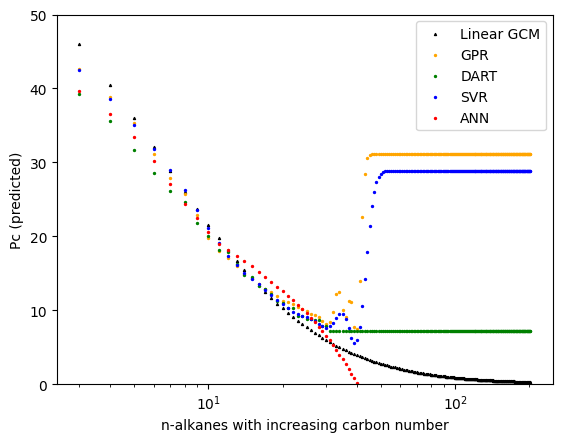

In [77]:
plt.scatter(df_res_1['C'], df_res_1['Pc_lgc'], s=2, c='black', marker='^',label='Linear GCM')
plt.scatter(df_res_1['C'], df_res_1['Pc_gpr'], s=2, c='orange', marker='o',label='GPR')
plt.scatter(df_res_1['C'], df_res_1['Pc_tre'], s=2, c='green', marker='o',label='DART')
plt.scatter(df_res_1['C'], df_res_1['Pc_svr'], s=2, c='blue', marker='o',label='SVR')
plt.scatter(df_res_1['C'], df_res_1['Pc_ann'], s=2, c='red', marker='o',label='ANN')

plt.legend()
plt.xlabel('n-alkanes with increasing carbon number')
plt.ylabel('Pc (predicted)')
plt.ylim(0, 50)
# plt.save
plt.xscale('log')
plt.savefig('thesis/Pc_nk.pdf')
plt.show()

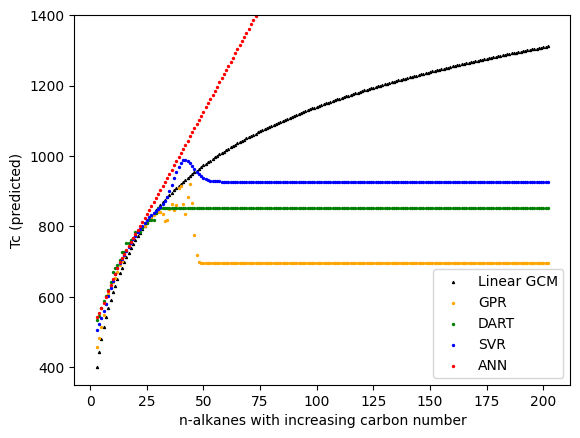

In [8]:
plt.scatter(df_res_1['C'], df_res_1['Tc_lgc'], s=2, c='black', marker='^',label='Linear GCM')
plt.scatter(df_res_1['C'], df_res_1['Tc_gpr'], s=2, c='orange', marker='o',label='GPR')
plt.scatter(df_res_1['C'], df_res_1['Tc_tre'], s=2, c='green', marker='o',label='DART')
plt.scatter(df_res_1['C'], df_res_1['Tc_svr'], s=2, c='blue', marker='o',label='SVR')
plt.scatter(df_res_1['C'], df_res_1['Tc_ann'], s=2, c='red', marker='o',label='ANN')

plt.ylim(350, 1400)
plt.legend()
plt.xlabel('n-alkanes with increasing carbon number')
plt.ylabel('Tc (predicted)')
# plt.xscale('log')
plt.savefig('thesis/Tc_nk.pdf')
plt.show()

In [62]:
df_res

,SMILES,C,Tc_lgc,Vc_lgc,Pc_lgc,Tc_svr,Vc_svr,Pc_svr,Zc_svr,Pc_tre,Tc_tre,Zc_cal,Pc_ann,Pc_gpr,Tc_ann,Tc_gpr,Zc_tre,Zc_ann,Zc_gpr
0,CCC,3,400.018859,208.370884,46.070082,505.993247,274.871612,42.518480,0.271541,39.298855,534.445176,0.289133,39.681400,42.568752,543.010072,455.898895,0.263456,0.272593,0.273093
1,CCCC,4,443.865604,265.295470,40.532517,521.415770,320.238944,38.636955,0.271484,35.595452,545.626890,0.291880,36.548090,38.814186,554.444322,482.283234,0.262584,0.274280,0.279625
2,CCCCC,5,481.109268,322.220056,35.937513,539.693318,371.209761,35.006175,0.270189,31.717789,568.023510,0.289987,33.427030,35.328339,566.727043,514.076660,0.260928,0.273350,0.279437
3,CCCCCC,6,513.480783,379.144641,32.082689,559.663436,425.377778,31.811048,0.267634,28.536603,586.793419,0.285413,30.180322,31.095243,583.208767,548.160706,0.256773,0.270655,0.271703
4,CCCCCCC,7,542.108665,436.069227,28.817204,580.694835,481.023396,28.942357,0.263860,26.134945,603.228353,0.279282,27.055317,27.825535,599.697627,579.133667,0.250679,0.265501,0.263581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,709,1620.601806,40397.128513,0.072090,927.248214,1309.219111,28.844809,0.217160,7.135363,851.054291,0.021651,-430.622660,31.132708,8899.800696,696.119629,0.109592,-2.893113,0.240020
707,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,710,1620.950085,40454.053098,0.072034,927.248214,1309.219111,28.844809,0.217160,7.135363,851.054291,0.021660,-431.266598,31.132708,8911.596251,696.119629,0.109592,-2.897580,0.240020
708,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,711,1621.297876,40510.977684,0.071979,927.248214,1309.219111,28.844809,0.217160,7.135363,851.054291,0.021669,-431.910448,31.132708,8923.392646,696.119629,0.109592,-2.902047,0.240020
709,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,712,1621.645179,40567.902270,0.071923,927.248214,1309.219111,28.844809,0.217160,7.135363,851.054291,0.021678,-432.554357,31.132708,8935.189881,696.119629,0.109592,-2.906514,0.240020


In [69]:
df_res['Zc_bestml'] = (df_res['Pc_gpr'] * df_res['Vc_svr']/1000) / (0.083* df_res['Tc_svr'])

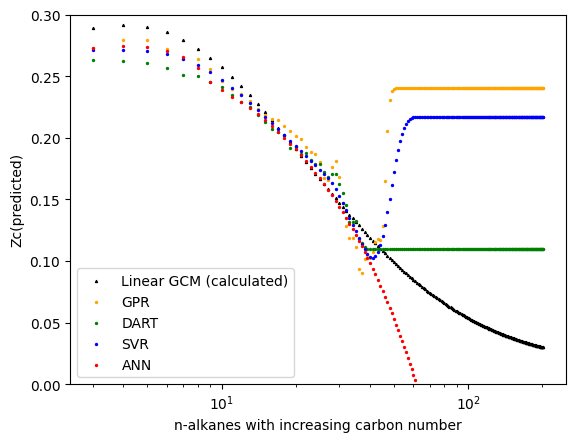

In [73]:
plt.scatter(df_res_1['C'], df_res_1['Zc_cal'], s=2, c='black', marker='^',label='Linear GCM (calculated)')
plt.scatter(df_res_1['C'], df_res_1['Zc_gpr'], s=2, c='orange', marker='o',label='GPR')
plt.scatter(df_res_1['C'], df_res_1['Zc_tre'], s=2, c='green', marker='o',label='DART')
plt.scatter(df_res_1['C'], df_res_1['Zc_svr'], s=2, c='blue', marker='o',label='SVR')
plt.scatter(df_res_1['C'], df_res_1['Zc_ann'], s=2, c='red', marker='o',label='ANN')

plt.xlabel('n-alkanes with increasing carbon number')
plt.ylim(0, 0.3)
plt.ylabel('Zc(predicted)')
plt.legend()
plt.xscale('log')
plt.savefig('thesis/Zc_nk.pdf')

plt.show()

In [63]:
df_res.to_excel('data/nklane_res.xlsx', index=False)